In [158]:
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
import re
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from tqdm import tqdm

# SB3 imports
import gymnasium as gym
from sb3_contrib import RecurrentPPO

sys.path.append(os.path.join(os.path.curdir, '../../src'))

import orbits
import cameras

from access import *
from orbits import *
from constants import *
from cameras import *
from schedulers import *
from vector import *
from AdEMAMix import AdEMAMix

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# Make a gym environment 

class LookaheadEnv(gym.Env):
    def __init__(self):
        # Load world cities requests...
        self.requests = []
        # Open the CSV and process the lines
        with open('../../data/worldcities/worldcities.csv', 'r', encoding='utf8') as f:
            f.readline()  # Skip the header line
            i = 0
            for line in f:
                parts = re.split(r'(?:",")|"', line)
                # Extract the latitude, longitude, and city name
                lat = float(parts[3])
                lon = float(parts[4])
                city = parts[2]
                # Create a new Request object and append it to the list
                self.requests.append(request(len(self.requests), lat, lon, city))
                i += 1
                if i >= 10000:
                    break

        # Create the access scheduler
        t0 = datetime.datetime(2024, 1, 1, 12, 0, 0)
        orbit = circular_orbit(a=Constants.R_E+400, i=np.deg2rad(51.6), Omega=np.pi, M=np.pi/2, t=t0)
        t_end = datetime.datetime(2024, 1, 3, 12, 0, 0)
        self.accesses = get_accesses(self.requests, orbit, 500, 30, t0, t_end)

        # first 2 are stop actions
        # next is time in future actions
        # next 3 are camera (euler) angles
        self.action_space = gym.spaces.Box(
            low = np.array([-np.inf, -np.inf, 0, -np.pi, -np.pi, -np.pi]),
            high = np.array([np.inf, np.inf, np.inf, np.pi, np.pi, np.pi]),
            shape=(6,)
        )

        self.observation_space = gym.spaces.Dict({
            'target_task': gym.spaces.Box(
                low = np.array([-np.inf, -np.inf, -np.inf]),
                high = np.array([np.inf, np.inf, np.inf]),
                shape=(3,)
            ),
            'all_tasks':
                gym.spaces.Box(
                    low = np.array([-np.inf, -np.inf, -np.inf]),
                    high = np.array([np.inf, np.inf, np.inf]),
                    shape=(3,)
                ),
        })

    def reset(self):   
        pass

    def step(self, action):
        return obs, reward, terminated, truncated, info


In [16]:
env = LookaheadEnv()

# model = RecurrentPPO('MlpLstmPolicy', env, verbose=1)
# model.learn(total_timesteps=10000)

In [2]:
# Analyze how many upcoming tasks there are...
requests = []
# Open the CSV and process the lines
with open('../../data/worldcities/worldcities.csv', 'r', encoding='utf8') as f:
    f.readline()  # Skip the header line
    i = 0
    for line in f:
        parts = re.split(r'(?:",")|"', line)
        # Extract the latitude, longitude, and city name
        lat = float(parts[3])
        lon = float(parts[4])
        city = parts[2]
        # Create a new Request object and append it to the list
        requests.append(request(len(requests), lat, lon, city))
        i += 1
        if i >= 10000:
            break

In [28]:
# Create the access scheduler
t0 = datetime.datetime(2024, 1, 1, 12, 0, 0)
orbit = circular_orbit(a=Constants.R_E+400, i=np.deg2rad(51.6), Omega=np.pi, M=np.pi/2, t=t0)
t_end = datetime.datetime(2024, 1, 4, 12, 0, 0)
accesses = get_accesses(requests, orbit, 500, 30, t0, t_end)
horizon_distance = orbits.horizon_distance(orbit)

print(f"Number of accesses: {len(accesses)}")
print(f"Horizon distance: {horizon_distance}")

counts = []
dt = datetime.timedelta(minutes=1)
total_steps = int((t_end - t0).total_seconds() / dt.total_seconds())

for i in tqdm(range(total_steps)):
    orbit = orbits.propagate_orbit(orbit, dt)
    # Orbit to ECI
    r, v = kepler2eci(orbit)
    # Get accesses in ECI
    t = t0 + i*dt
    # accesses_eci = [latlong2eci(j.lat, j.long, j.time) for j in accesses if j.time > i.time and j.time < i.time + datetime.timedelta(minutes=30)]
    accesses_eci = [latlong2eci(j.lat, j.long, j.time) for j in accesses if j.time > t and j.time < t + datetime.timedelta(minutes=30)]

    # Get the horizon distance
    if(len(accesses_eci) == 0):
        counts.append(0)
        continue
    
    total_count = np.sum(dist(r, np.array(accesses_eci)) < horizon_distance)

    counts.append(total_count)



Number of accesses: 20548
Horizon distance: 2293.9921534303467


100%|██████████| 4320/4320 [00:48<00:00, 89.34it/s] 


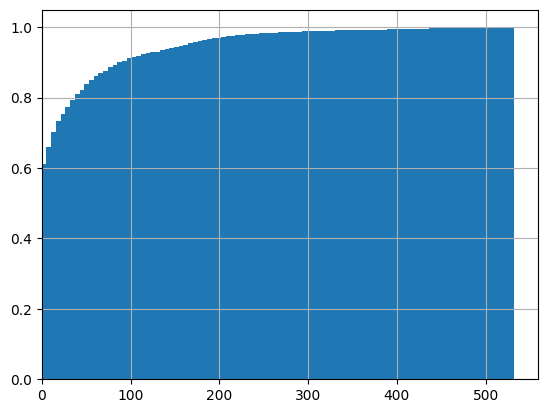

Max Length:  532


In [35]:
plt.hist(counts, cumulative=True, density=True, bins=100)
plt.grid()
plt.xlim(0)
# plt.ylim(0, 1)
# plt.yticks(np.arange(0, 1.1, 0.1))
plt.show()

print("Max Length: ", np.max(counts))

In [134]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset

# Create the dataset of vector observations
input_size = 532 # max total visible
tensor_data = torch.ones((total_steps, input_size, 3)) * -1
horizon_distance = orbits.horizon_distance(orbit)

t0 = datetime.datetime(2024, 1, 1, 12, 0, 0)
orbit = circular_orbit(a=Constants.R_E+400, i=np.deg2rad(51.6), Omega=np.pi, M=np.pi/2, t=t0)
t_end = datetime.datetime(2024, 1, 4, 12, 0, 0)
accesses = get_accesses(requests, orbit, 500, 30, t0, t_end)
horizon_distance = orbits.horizon_distance(orbit)

for i in tqdm(range(total_steps)):
    orbit = orbits.propagate_orbit(orbit, dt)
    # Orbit to ECI
    r, v = kepler2eci(orbit)
    # Get accesses in ECI
    t = t0 + i*dt
    # accesses_eci = [latlong2eci(j.lat, j.long, j.time) for j in accesses if j.time > i.time and j.time < i.time + datetime.timedelta(minutes=30)]
    accesses_eci = [latlong2eci(j.lat, j.long, t) for j in accesses if j.time > t and j.time < t + datetime.timedelta(minutes=30)]
    accesses_eci = [a for a in accesses_eci if dist(r, a.reshape((1, 3))) < horizon_distance]

    if(len(accesses_eci) == 0):
        continue
    
    tensor_data[i, :len(accesses_eci), :] = torch.tensor(accesses_eci - r)

100%|██████████| 4320/4320 [03:10<00:00, 22.69it/s]


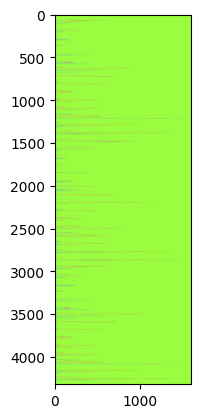

In [135]:
dataset = TensorDataset(tensor_data.permute(0, 2, 1))
plt.imshow(tensor_data.flatten(start_dim=1, end_dim=2).numpy(), cmap='turbo')
plt.show()

In [152]:
class Autoencoder1D(torch.nn.Module):
    def __init__(self, input_size, latent_size):
        super(Autoencoder1D, self).__init__()
        # -----------------
        # ENCODER
        # -----------------
        self.encoder = nn.Sequential(
            # 1) in: (3, 532)  -- keep length = 532 with kernel_size=7, padding=3
            nn.Conv1d(3, 6, kernel_size=7, stride=1, padding=3),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),                # out: (16, 266)

            # 2) in: (16, 266)
            nn.Conv1d(6, 12, kernel_size=7, stride=1, padding=3),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),                # out: (32, 133)

            # 3) in: (32, 133)
            # nn.Conv1d(32, 64, kernel_size=7, stride=1, padding=3),
            # nn.LeakyReLU(),
            # nn.MaxPool1d(2),                # out: (64, 66)
            
            nn.Flatten(),                   # out: 64 * 66 = 4224
            nn.Linear(1596, latent_size)    # => latent_size
        )
        
        # -----------------
        # DECODER
        # -----------------
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 1596),
            nn.Unflatten(dim=1, unflattened_size=(12, 133)),
            # Now we want to go back from length=66 to 532 in 3 steps: 66->133->266->532
            
            # 1) 66 -> 133
            #    kernel_size=7, stride=2, padding=2, output_padding=0  gives 133
            # nn.ConvTranspose1d(
            #     in_channels=64,
            #     out_channels=32,
            #     kernel_size=7,
            #     stride=2,
            #     padding=2,
            #     output_padding=0
            # ),
            # nn.LeakyReLU(),
            
            # 2) 133 -> 266
            #    kernel_size=7, stride=2, padding=3, output_padding=1  gives 266
            nn.ConvTranspose1d(
                in_channels=12,
                out_channels=6,
                kernel_size=7,
                stride=2,
                padding=3,
                output_padding=1
            ),
            nn.LeakyReLU(),
            
            # 3) 266 -> 532
            #    kernel_size=7, stride=2, padding=3, output_padding=1  gives 532
            nn.ConvTranspose1d(
                in_channels=6,
                out_channels=3,
                kernel_size=7,
                stride=2,
                padding=3,
                output_padding=1
            ),
        )
        

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [167]:
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Try a few different autoencoder sizes
num_epochs = 1000
latent_sizes = [1024, 512, 256, 128, 64, 32, 16]
losses = torch.zeros((len(latent_sizes), num_epochs))

for i, latent_size in enumerate(latent_sizes):
    # Create the autoencoder model
    model = Autoencoder1D(input_size, latent_size)
    model.to(device)

    # Create the optimizer
    optimizer = AdEMAMix(model.parameters(), lr=1e-4)

    # Train the model
    for epoch in tqdm(range(num_epochs)):
        for data in dataloader:
            # Get the data
            x = data[0].to(device)

            # Forward pass
            outputs = model(x)
            loss = nn.MSELoss()(outputs, x)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Record loss
            losses[i, epoch] += loss.item()

        # if(epoch % 10 == 0):
        #     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {losses[i, epoch]:.4f}')

100%|██████████| 1000/1000 [16:07<00:00,  1.03it/s]


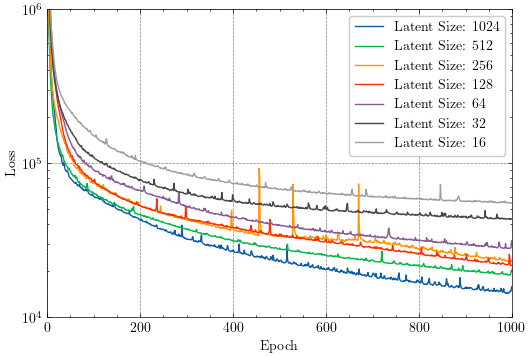

In [174]:
# Plot losses on the same graph
import scienceplots
plt.style.use(["science", "grid"])

plt.figure(figsize=(6, 4))
for i, latent_size in enumerate(latent_sizes):
    plt.plot(losses[i], label=f'Latent Size: {latent_size}')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.xlim(0, 1000)
plt.ylim(1e4, 1e6)
plt.legend()
plt.show()

In [ ]:
# 